## Titanic Survivor Predictor
<br>

 Here we predict if a person survived or not based on the dataset of
 [this](https://www.kaggle.com/c/titanic) competition on Kaggle.

<br>

This is the data dictionary:

<br>

|Variable	|Definition	|Key |
|:-:|:-:|:-:|
|survival	|Survival	|0 = No, 1 = Yes
|pclass	|Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd
|sex	|Sex	
|Age	|Age in years	
|sibsp	|# of siblings / spouses aboard the Titanic	
|parch	|# of parents / children aboard the Titanic	
|ticket	|Ticket number	
|fare	|Passenger fare	
|cabin	|Cabin number	
|embarked	|Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton

### 1. Setting up the environment

In [1]:
# Tools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression

# Evaluation


### 2. Importing the data

In [49]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Checking the table
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 3. Table Analysis
<br>
    Analysing the table content, its null values, data types and etc.
I'll base my analysis on the train data as that is the well we will fit our model but I'll perform the transformations on both tables.

<br><br>

### 3.1 Handling missing numerical data

In [50]:
# Checking the percentage of null values for each category
(train.isna().sum()/len(train))*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Even though 77% of the cabin values are null, it does not mean that the value is missing but that the person did not have a cabin. Because of that, I'm going to replace the cabin value 'NaN' as 0.

In [52]:
combined = [train,test]

for dataset in combined:
    for label, content in dataset.items():
        # Transforms every missing Cabin data into 0
        dataset.Cabin.fillna(inplace = True, value = 0)
        
        if pd.api.types.is_numeric_dtype(content):
            # Makes every other numerical data missing in its category's mean
            dataset[label].fillna(dataset[label].mean(), inplace = True)
                
# Checking if there's any more numerical missing data
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       2
dtype: int64

In [26]:
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

As there Embarked is a string type and there are only 2 missing on the train set ( 2 represents 0.22% of the train data), I'll drop those rows.
As I want to drop specific rows, I'll transpose the matrix, hence the T and discover with passengers do not have a Embarked value.

In [53]:
train_T = train.T

for label, content in train_T.items():
    if pd.isna(content).sum():
        train_T.drop(label, axis = 1, inplace = True)

#ReTransposing the matrix and checking for NaN values
train = train_T.T

# Updating the combined list
combined1 = [train, test]

train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### 3.2 Handling string data
<br>

#### 3.2.1 Turning Female and Male into numbers

In [54]:
for dataset in combined1:
    dataset.Sex.replace('female',  1, inplace = True)
    dataset.Sex.replace('male', 0, inplace = True)

# Checking the changes    
train.Sex.head()

0    0
1    1
2    1
3    1
4    0
Name: Sex, dtype: int64

In [55]:
# As the name is not important to us, we'll drop it
for dataset in combined1:
    dataset.drop('Name', axis = 1, inplace = True)
    
# Checking changes
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,0,22,1,0,A/5 21171,7.25,0,S
1,2,1,1,1,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,1,26,0,0,STON/O2. 3101282,7.925,0,S
3,4,1,1,1,35,1,0,113803,53.1,C123,S
4,5,0,3,0,35,0,0,373450,8.05,0,S


#### 3.2.2 Handling Cabin Data
<br>
The Cabin data is made of a Letter followed by number, I myself don't know exactly what they mean but it must correspond to the cabin's localization on the Titanic, which makes a lot of difference in a matter of survival.

In [56]:
for dataset in combined1:
    for content in dataset.Cabin.items():
        print(content[1])

0
C85
0
C123
0
0
E46
0
0
0
G6
C103
0
0
0
0
0
0
0
0
0
D56
0
A6
0
0
0
C23 C25 C27
0
0
0
B78
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
D33
0
B30
C52
0
0
0
0
0
C83
0
0
0
F33
0
0
0
0
0
0
0
0
F G73
0
0
0
0
0
0
0
0
0
0
0
0
C23 C25 C27
0
0
0
E31
0
0
0
A5
D10 D12
0
0
0
0
D26
0
0
0
0
0
0
0
C110
0
0
0
0
0
0
0
B58 B60
0
0
0
0
E101
D26
0
0
0
F E69
0
0
0
0
0
0
0
D47
C123
0
B86
0
0
0
0
0
0
0
0
F2
0
0
C2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
E33
0
0
0
B19
0
0
0
A7
0
0
C49
0
0
0
0
0
F4
0
A32
0
0
0
0
0
0
0
F2
B4
B80
0
0
0
0
0
0
0
0
0
G6
0
0
0
A31
0
0
0
0
0
D36
0
0
D15
0
0
0
0
0
C93
0
0
0
0
0
C83
0
0
0
0
0
0
0
0
0
0
0
0
0
0
C78
0
0
D35
0
0
G6
C87
0
0
0
0
B77
0
0
0
0
E67
B94
0
0
0
0
C125
C99
0
0
0
C118
0
D7
0
0
0
0
0
0
0
0
A19
0
0
0
0
0
0
B49
D
0
0
0
0
C22 C26
C106
B58 B60
0
0
0
E101
0
C22 C26
0
C65
0
E36
C54
B57 B59 B63 B66
0
0
0
0
0
0
C7
E34
0
0
0
0
0
C32
0
D
0
B18
0
C124
C91
0
0
0
C2
E40
0
T
F2
C23 C25 C27
0
0
0
F33
0
0
0
0
0
C128
0
0
0
0
E33
0
0
0
0
0
0
0
0
0
D37
0
0
B35
E50
0
0
0
0
0
0
C82
0
0
0
0
0
0
0
0
0
0
0


As we can see, there are some passengers that have more than one cabin, let's create a column for number of cabins.

In [57]:
for dataset in combined1:
    # Creating columns filled with zeros 
    
    dataset['Cabins'] = np.zeros(len(dataset)) # numb of cabins
    dataset['Cabin_Number'] = np.zeros(len(dataset)) # number of the cabin
    dataset['Cabin_Letter'] = np.zeros(len(dataset)) # letter of the cabin
    for content in dataset.Cabin.items():
        index, info = content
        if type(info) != int:
            info = info.split(' ') # splitting the string at ' '
            dataset.Cabins.loc[index] = len(info) # cabins = number of cabins
            if dataset.Cabins.loc[index] >= 1: # if more than one cabin
                dataset.Cabin_Number.loc[index] = info[0][1:len(info[0])]
                dataset.Cabin_Letter.loc[index] = info[0][0]

train.head()            

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabins,Cabin_Number,Cabin_Letter
0,1,0,3,0,22,1,0,A/5 21171,7.25,0,S,0.0,0,0
1,2,1,1,1,38,1,0,PC 17599,71.2833,C85,C,1.0,85,C
2,3,1,3,1,26,0,0,STON/O2. 3101282,7.925,0,S,0.0,0,0
3,4,1,1,1,35,1,0,113803,53.1,C123,S,1.0,123,C
4,5,0,3,0,35,0,0,373450,8.05,0,S,0.0,0,0


As we've already used the first letter information, now I will get the numbers and then drop the Cabin column.

OBS: As the passengers who have more than one cabin have each cabin close together, I won't consider the other cabins locations.

In [58]:
# Dropping the Cabin column & Ticket (as it's not relevant to us)
for dataset in combined1:
    dataset.drop('Cabin', axis = 1, inplace = True)
    dataset.drop('Ticket', axis = 1, inplace = True)
    
# Checking changes
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabins,Cabin_Number,Cabin_Letter
0,1,0,3,0,22,1,0,7.25,S,0.0,0,0
1,2,1,1,1,38,1,0,71.2833,C,1.0,85,C
2,3,1,3,1,26,0,0,7.925,S,0.0,0,0
3,4,1,1,1,35,1,0,53.1,S,1.0,123,C
4,5,0,3,0,35,0,0,8.05,S,0.0,0,0


#### 3.2.3 Turning  into categorical data 
<br>
<br>

Here I'll transform Cabin_Letter, Embarked and Class into categorical features, even though Class is already numerical, it is a category, as the passenger's class is import not only quantitatively. 

In [59]:
'''------TRAIN--------'''

# Encoding the  columns
dummies_letter = pd.get_dummies(train.Cabin_Letter, prefix = 'Cabin_Letter', prefix_sep = '_')
dummies_embarked = pd.get_dummies(train.Embarked, prefix = 'Embarked', prefix_sep = '_')
dummies_class = pd.get_dummies(train.Pclass, prefix = 'Class', prefix_sep = '_')

# Dropping the original column ( as we do not need it anymore)
train.drop('Cabin_Letter', axis = 1, inplace = True)
train.drop('Embarked', axis = 1, inplace = True)
train.drop('Pclass', axis = 1, inplace = True)

# Joining the dummies to the DataFrame
train = pd.concat([train, dummies_letter, dummies_embarked,dummies_class], axis = 1)

# Checking changes
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabins,Cabin_Number,...,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,0,22,1,0,7.25,0.0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,1,38,1,0,71.2833,1.0,85,...,0,1,0,0,0,0,0,1,0,0
2,3,1,3,1,26,0,0,7.925,0.0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,1,35,1,0,53.1,1.0,123,...,0,1,0,0,0,0,0,0,0,1
4,5,0,3,0,35,0,0,8.05,0.0,0,...,0,0,0,0,0,0,0,0,0,1


In [60]:
'''------TEST--------'''

# Encoding the  columns
dummies_letter = pd.get_dummies(test.Cabin_Letter, prefix = 'Cabin_Letter', prefix_sep = '_')
dummies_embarked = pd.get_dummies(test.Embarked, prefix = 'Embarked', prefix_sep = '_')
dummies_class = pd.get_dummies(test.Pclass, prefix = 'Class', prefix_sep = '_')

# Dropping the original column ( as we do not need it anymore)
test.drop('Cabin_Letter', axis = 1, inplace = True)
test.drop('Embarked', axis = 1, inplace = True)
test.drop('Pclass', axis = 1, inplace = True)

# Joining the dummies to the DataFrame
test = pd.concat([test, dummies_letter, dummies_embarked, dummies_cest], axis = 1)

# Checking changes
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabins,Cabin_Number,Cabin_Letter_0.0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Embarked_C,Embarked_Q,Embarked_S
0,892,3,0,34.5,0,0,7.8292,0.0,0,1,0,0,0,0,0,0,0,0,1,0
1,893,3,1,47.0,1,0,7.0000,0.0,0,1,0,0,0,0,0,0,0,0,0,1
2,894,2,0,62.0,0,0,9.6875,0.0,0,1,0,0,0,0,0,0,0,0,1,0
3,895,3,0,27.0,0,0,8.6625,0.0,0,1,0,0,0,0,0,0,0,0,0,1
4,896,3,1,22.0,1,1,12.2875,0.0,0,1,0,0,0,0,0,0,0,0,0,1


### 4. Visualizing the data
<br>

#### 4.1 Correlation Matrix
<br><br>
With the Correlation matrix we can see the importance of each categorical feature on the end result

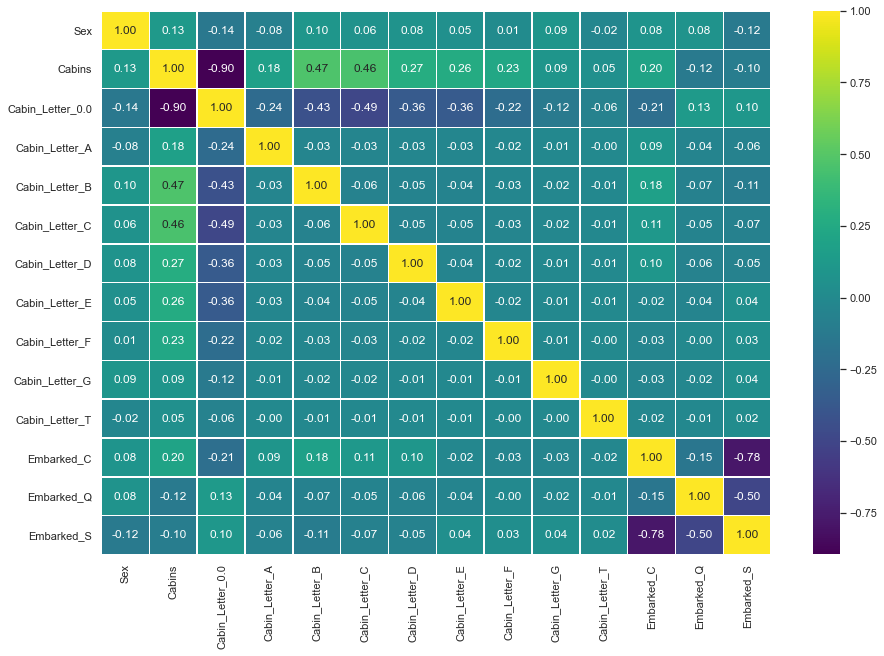

In [71]:
sns.set_theme(style = 'darkgrid')

corr_matrix = train.corr()
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(corr_matrix,
                   annot = True,
                   linewidths = 0.5,
                   fmt = '.2f',
                   cmap = 'viridis');

#### 4.2 Age and Survival

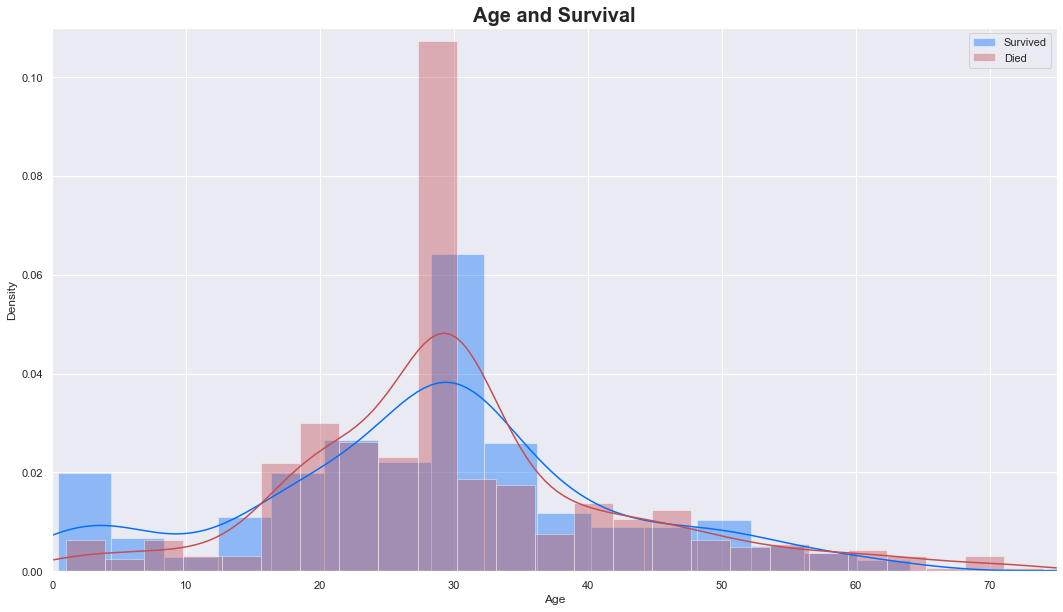

In [181]:
# Constant Size of the Figure
plt.rcParams["figure.figsize"] = (18,10)
sns.distplot(train.Age[train.Survived == 1], label = 'Survived',color = '#036ffc' )
sns.distplot(train.Age[train.Survived == 0], label = 'Died',color = 'r')
plt.title('Age and Survival', fontsize = 20, fontweight = 'bold')
plt.xlim(0,75)
plt.ylim(0,0.11)
plt.legend();

#### 4.3 Class and Survival

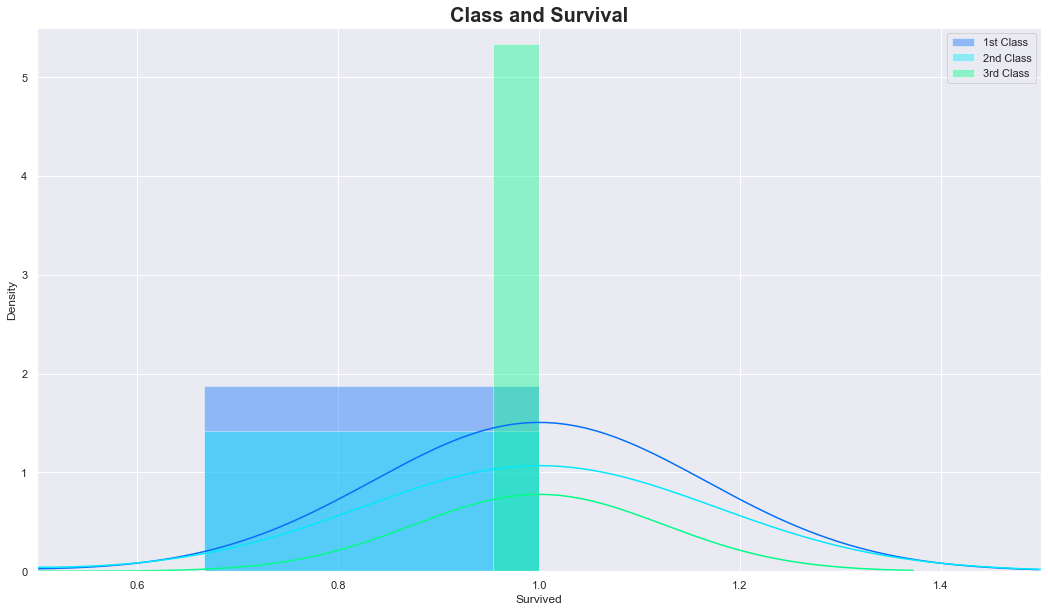

In [162]:
sns.distplot(train.Survived[train.Pclass == 1], label = '1st Class',color = '#036ffc' )
sns.distplot(train.Survived[train.Pclass == 2], label = '2nd Class',color = '#03e8fc' )
sns.distplot(train.Survived[train.Pclass == 3], label = '3rd Class',color = '#03fc88')
plt.title('Class and Survival', fontsize = 20, fontweight = 'bold');
plt.xlim(0.5,1.5)
plt.ylim(0,5.5)
plt.legend();

#### 4.4 Gender and Survival

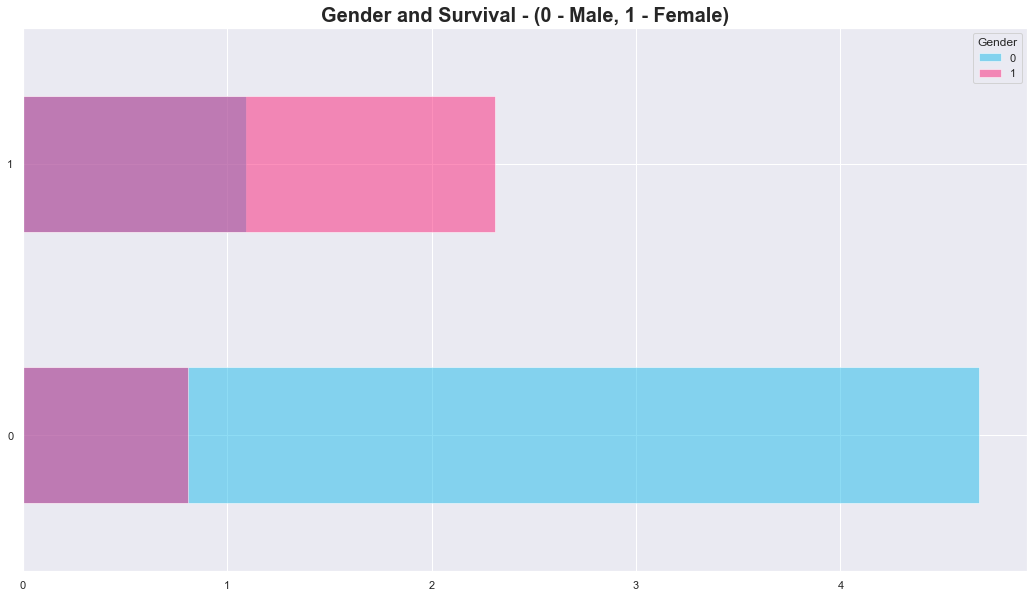

In [232]:
male = train.Survived[train.Sex == 0].value_counts().sort_index()
female = train.Survived[train.Sex == 1].value_counts().sort_index()

ax1 = fig.add_subplot(121)
male_plot = (male/100).plot.barh(alpha=0.5, color = '#1ebbeb')
female_plot = (female/100).plot.barh( color = '#FA2379', alpha=0.5)
plt.title('Gender and Survival - (0 - Male, 1 - Female)', fontsize = 20, fontweight = 'bold');
ax1.set_ylim(-1, 2) 
plt.legend(train.Sex, title = 'Gender');

In purple we can see the survival rate, from that we can see that the survival rate of women was far higher than men's.

### 5 Fit Models